In [1]:
import numpy as np
from scipy import sparse
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ipywidgets import interact, interactive
import ipywidgets as widgets
import time

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.family'] = ['WenQuanYi Zen Hei']
plt.rcParams['font.serif'] = ['WenQuanYi Zen Hei']
# matplotlib.rcParams['font.serif'] = ['WenQuanYi Zen Hei']

In [39]:
MAX_CAR=20
MAX_MOVE=5
MOVE_COST=2
REWARD=10
DISCOUNT=0.9

lam_a=3
lam_b=4
sig_a=3
sig_b=2


In [28]:
Ra=np.zeros((MAX_CAR+1,))
for s in range(MAX_CAR+1):
    tmp=0
    for k in range(s+1):
        pk=stats.poisson.pmf(k,lam_a)
        tmp+=pk
        Ra[s]+=pk*k
    Ra[s]+=s*(1-tmp)
Ra=Ra*REWARD

Rb=np.zeros((MAX_CAR+1,))
for s in range(MAX_CAR+1):
    tmp=0
    for k in range(s+1):
        pk=stats.poisson.pmf(k,lam_b)
        tmp+=pk
        Rb[s]+=pk*k
    Rb[s]+=s*(1-tmp)
Rb=Rb*REWARD
R=Ra.reshape((-1,1))+Rb.reshape((1,-1))

In [36]:
Pa=np.zeros((MAX_CAR+1,MAX_CAR+1))
for c1_new in range(0,MAX_CAR+1):
    for c1_next in range(MAX_CAR+1):
        bl=0 if c1_next>c1_new else c1_new-c1_next #借的最小
        for b in range(bl,c1_new+1):
            r=c1_next-(c1_new-b)
            Pa[c1_new,c1_next]+=stats.poisson.pmf(b,lam_a)*stats.poisson.pmf(r,sig_a)
        ## 借完了，还c1_next辆
        b_tmp=[stats.poisson.pmf(b,lam_a) for b in range(0,c1_new+1)] ##错误 range(bl,c1_new+1)
        Pa[c1_new,c1_next]+=(1-sum(b_tmp))*stats.poisson.pmf(c1_next,sig_a)
    ## 当c1_next=MAX_CAR
    b_tmp=[stats.poisson.pmf(b,lam_a) for b in range(0,c1_new+1)]
    r_tmp=[stats.poisson.pmf(r,sig_a) for r in range(0,MAX_CAR+1)]
    Pa[c1_new,MAX_CAR]+=(1-sum(b_tmp))*(1-sum(r_tmp))
    for b in range(c1_new+1):
        r_min= MAX_CAR-(c1_new-b)# 最少归还数量，使得c1_next>MAX_CAR
        p_r=1-sum(r_tmp[:(r_min+1)])
        Pa[c1_new,MAX_CAR]+=stats.poisson.pmf(b,lam_a)*p_r

Pb=np.zeros((MAX_CAR+1,MAX_CAR+1))
for c2_new in range(0,MAX_CAR+1):
    for c2_next in range(MAX_CAR+1):
        bl=0 if c2_next>c2_new else c2_new-c2_next #借的最小
        for b in range(bl,c2_new+1):
            r=c2_next-(c2_new-b)
            Pb[c2_new,c2_next]+=stats.poisson.pmf(b,lam_b)*stats.poisson.pmf(r,sig_b)
        ## 借完了，还c1_next辆
        b_tmp=[stats.poisson.pmf(b,lam_b) for b in range(0,c2_new+1)] ##错误 range(bl,c1_new+1)
        Pb[c2_new,c2_next]+=(1-sum(b_tmp))*stats.poisson.pmf(c2_next,sig_b)
    ## 当c1_next=MAX_CAR
    b_tmp=[stats.poisson.pmf(b,lam_b) for b in range(0,c2_new+1)]
    r_tmp=[stats.poisson.pmf(r,sig_b) for r in range(0,MAX_CAR+1)]
    Pb[c2_new,MAX_CAR]+=(1-sum(b_tmp))*(1-sum(r_tmp))
    for b in range(c2_new+1):
        r_min= MAX_CAR-(c2_new-b)# 最少归还数量，使得c1_next>MAX_CAR
        p_r=1-sum(r_tmp[:(r_min+1)])
        Pb[c2_new,MAX_CAR]+=stats.poisson.pmf(b,lam_b)*p_r

2.271092414855957


Text(0.5, 1.0, '$\\pi^*$')

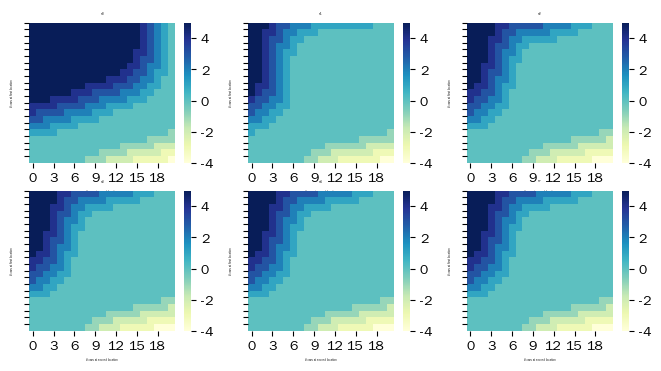

In [57]:
policy=np.zeros((MAX_CAR+1,MAX_CAR+1),dtype=np.int32)
v=np.zeros((MAX_CAR+1,MAX_CAR+1))
v_new=np.zeros((MAX_CAR+1,MAX_CAR+1))

theta=1e-3

policy_stable=False
_, axes = plt.subplots(2, 3,figsize=(8, 4))
# 调整子图的间距，wspace=0.1为水平间距，hspace=0.2为垂直间距
# plt.subplots_adjust(wspace=0.1, hspace=0.2)
# 这里将子图形成一个1*6的列表
axes = axes.flatten()

iter_num=0
start=time.time()
while not policy_stable:
    ### 策略评估
    while True:
        for c1 in range(MAX_CAR+1):
            for c2 in range(MAX_CAR+1):
                a=policy[c1,c2]
                c1_new=c1-a
                c2_new=c2+a
                P_tmp=Pa[c1_new,:].reshape((-1,1))@Pb[c2_new,:].reshape((1,-1))
                v_new[c1,c2]=-MOVE_COST*np.abs(a)+R[c1_new,c2_new]+DISCOUNT*np.sum(P_tmp*v)
        delta=np.max(np.abs(v_new-v))
        v=v_new.copy()
        if delta<theta:
            break
    ### 策略提升
    policy_stable=True
    for c1 in range(MAX_CAR+1):
        for c2 in range(MAX_CAR+1):
            al=-min(5,c2,MAX_CAR-c1)
            au=min(5,c1,MAX_CAR-c2)
            base=v[c1,c2]
            for a in range(al,au+1):
                c1_new=c1-a
                c2_new=c2+a
                P_tmp=Pa[c1_new,:].reshape((-1,1))@Pb[c2_new,:].reshape((1,-1))
                v_a=-MOVE_COST*np.abs(a)+R[c1_new,c2_new]+DISCOUNT*np.sum(P_tmp*v)
                if v_a>base+theta*10:
                    policy[c1,c2]=a
                    base=v_a
                    policy_stable=False
    if iter_num<5:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iter_num])
        # 定义标签与标题
        fig.set_ylabel('# cars at first location', fontsize=2)
        fig.set_yticks(list(reversed(range(20 + 1))))
        fig.set_xlabel('# cars at second location', fontsize=2)
        fig.set_title('$\pi{}$'.format(iter_num), fontsize=2)
    iter_num+=1
end=time.time()
print(end-start)
fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[-1])
# 定义标签与标题
fig.set_ylabel('# cars at first location', fontsize=2)
fig.set_yticks(list(reversed(range(20 + 1))))
fig.set_xlabel('# cars at second location', fontsize=2)
fig.set_title('$\pi^*$', fontsize=2)